# Sentiment Analysis Model

### Importing the data

In [2]:
import pandas as pd

data = pd.read_csv("data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         4680 non-null   int64 
 1   name          4680 non-null   object
 2   product_url   4680 non-null   object
 3   query_url     4680 non-null   object
 4   review_url    4680 non-null   object
 5   rating        4680 non-null   int64 
 6   review_title  4680 non-null   object
 7   review        4680 non-null   object
dtypes: int64(2), object(6)
memory usage: 292.6+ KB


### Removing unneccssary columns from dataframe

In [3]:
data.drop(["index", "product_url", "query_url", "review_url"], axis=1, inplace=True)

### Cleaning the data

In [4]:
import nltk
import re
from nltk.corpus import stopwords

stopwords = set(stopwords.words("english"))


def clean(text):
    lemmatizer = nltk.WordNetLemmatizer()
    text = str(text).encode("ascii", "ignore").decode("ascii")
    text = str(text).lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"'s", " ", text)
    text = re.sub(r"'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'d", " would ", text)
    text = re.sub(r"'ll", " will ", text)
    text = [word for word in text.split(" ") if word not in stopwords]
    text = " ".join(text)
    text = [lemmatizer.lemmatize(word) for word in text.split(" ")]
    text = " ".join(text)
    return text


data["name"] = data["name"].str.lower()
data["review_title"] = data["review_title"].apply(clean)
data["review"] = data["review"].apply(clean)
data.sample(5)

,name,rating,review_title,review
4633,"redmi note 12 pro 5g (stardust purple, 128 gb)",5,best market!,"good phone, battery backup good camera 9/10"
1301,nokia 105 plus,4,value-for-money,excellent build quality...
354,"infinix hot 30i (marigold, 64 gb)",5,simply awesome,absolutely amazing phone low price good design...
4111,"vivo v25 pro 5g (sailing blue, 128 gb)",5,must buy!,nice vivo v25 pro 5g nice karo display good pe...
4631,"redmi note 12 pro 5g (stardust purple, 128 gb)",4,pretty good,black color attracts lot dust. phone look great.


### Sentiment Analysis

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer

sentiments = SentimentIntensityAnalyzer()
data["positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["review"]]
data["negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["review"]]
data["neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["review"]]

In [6]:
def sentiment_score(x):
    a = x.positive
    b = x.negative
    c = x.neutral
    if a > b and a > c:
        sentiment = "Positive"
    elif b > a and b > c:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return sentiment


name_sentiment = data[["name", "positive", "negative", "neutral"]].apply(
    sentiment_score, axis=1
)
data["sentiment"] = name_sentiment

### Using Wordcloud to visualize the reviews data

Positive Sentiment Data Size:2183
Negative Sentiment Data Size:209
Neutral Sentiment Data Size:2129
Ambiguous Sentiment Data Size:159
Positive Sentiment Data Size:2183


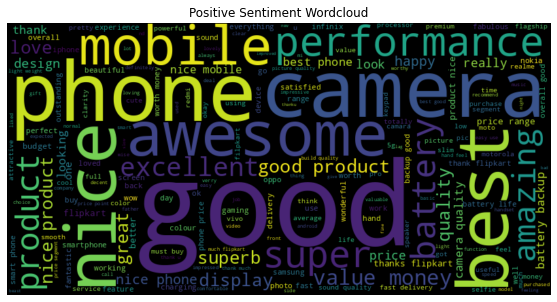

Neutral Sentiment Data Size:2129


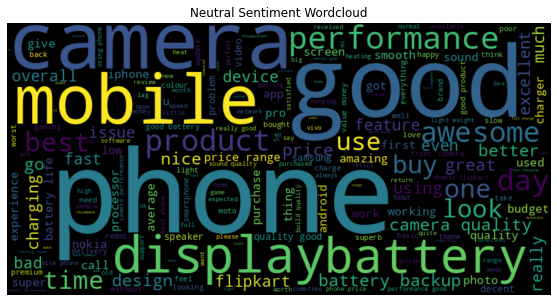

Negative Sentiment Data Size:209


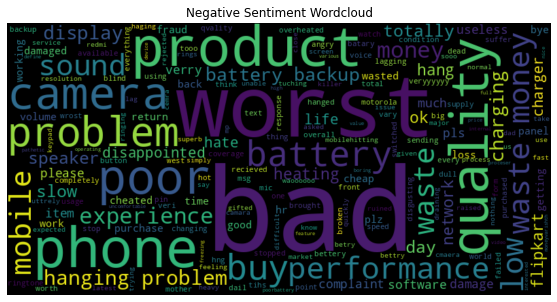

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

min_intensity = 0.5

# Positive
reviews = data.query(f"positive>{min_intensity}").review
print(f"positive sentiment data size:{len(reviews)}".title())
text_combined = " ".join(reviews)
positive_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# Negative
reviews = data.query(f"negative>{min_intensity}").review
print(f"negative sentiment data size:{len(reviews)}".title())
text_combined = " ".join(reviews)
negative_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# Neutral
reviews = data.query(f"neutral>{min_intensity}").review
print(f"neutral sentiment data size:{len(reviews)}".title())
text_combined = " ".join(reviews)
neutral_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# Ambiguous
reviews = data.query(
    f"not(positive>{min_intensity}|negative>{min_intensity}|neutral>{min_intensity})"
).review
print(f"Ambiguous Sentiment Data Size:{len(reviews)}")
text_combined = " ".join(reviews)
ambiguous_wordcloud = WordCloud(width=800, height=400).generate(text_combined)

for sentiment in ["positive", "neutral", "negative"]:
    reviews = data.query(f"{sentiment}>{min_intensity}").review
    print(f"{sentiment} sentiment data size:{len(reviews)}".title())
    text_combined = " ".join(reviews)
    wordcloud = WordCloud(width=800, height=400).generate(text_combined)
    plt.figure(figsize=(10, 5))
    plt.title(f"{sentiment} sentiment wordcloud".title())
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Creating word lists

In [8]:
def filter(word_cloud: WordCloud) -> list:
    excluded_words = [
        "good",
        "awesome",
        "best",
        "nice",
        "good good",
        "superb",
        "super",
        "thank",
        "amazing",
        "excellent",
        "great",
        "super",
        "happy",
        "love",
        "bad",
        "worst",
        "poor",
        "product",
        "mobile",
        "low",
        "waste",
        "waste money",
        "flipkart",
        "hate",
        "day",
    ]
    return [i for i in word_cloud.words_.keys() if i.lower() not in excluded_words]


words = {
    "positive": filter(positive_wordcloud),
    "negative": filter(negative_wordcloud),
    "neutral": filter(neutral_wordcloud),
    "ambiguous": filter(ambiguous_wordcloud),
}

### Vectorize the reviews

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
reviews_corpus = vectorizer.fit_transform(data.review)
reviews_corpus.shape

(4680, 5843)

### Encoding the target

In [10]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
sentiment = pd.DataFrame(label_enc.fit_transform(data["sentiment"]))
sentiment.shape

(4680, 1)

### Splitting the dataset for training and testing

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    reviews_corpus, sentiment, test_size=0.33, random_state=0
)
Y_train = Y_train.to_numpy().ravel()
Y_test = Y_test.to_numpy().ravel()
print("Train data shape ", X_train.shape, Y_train.shape)
print("Test data shape ", X_test.shape, Y_test.shape)

Train data shape  (3135, 5843) (3135,)
Test data shape  (1545, 5843) (1545,)


### Building classifier models and comparing them

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8129449838187702
Confusion Matrix:
[[  0   0   0]
 [ 69 595  78]
 [  3 139 661]]


In [14]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8116504854368932
Confusion Matrix:
[[ 58  13   3]
 [ 12 593 133]
 [  2 128 603]]


In [15]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8530744336569579
Confusion Matrix:
[[ 51   5   2]
 [ 21 639 109]
 [  0  90 628]]


In [16]:
from sklearn.ensemble import BaggingClassifier

classifier = BaggingClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.855663430420712
Confusion Matrix:
[[ 57  11   2]
 [ 14 637 109]
 [  1  86 628]]


In [17]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier().fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(f"Accuracy: {classifier.score(X_test, Y_test)}")
print("Confusion Matrix:")
print(confusion_matrix(Y_pred, Y_test))

Accuracy: 0.8543689320388349
Confusion Matrix:
[[ 60  10   3]
 [ 12 642 118]
 [  0  82 618]]
